In [19]:
import numpy as np
from service import train


with open(train.labelPath, 'r') as f:
    lines = f.readlines()
    actions = [line.strip().split()[0] for line in lines]
    labels = [line.strip().split()[1] for line in lines]
    
data = np.concatenate([
    np.load(f'{train.dataPath}/seq_twoFinger.npy')
], axis=0)

labels, actions

(['0', '1', '2', '3'], ['clenching', 'away', 'come', 'twoFinger'])

In [20]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_data = data[:, :, :-1]
labels = data[:, 0, -1]

y_data = to_categorical(labels, num_classes=len(actions))

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022)

x_train.shape, y_train.shape, x_train, y_train

((185, 30, 99),
 (185, 4),
 array([[[ 5.4353637e-01,  7.4992704e-01, -3.4441413e-07, ...,
           3.4009895e+01,  1.3230637e+02,  9.7824450e+00],
         [ 5.4445720e-01,  7.5155163e-01, -3.8772325e-07, ...,
           4.3685005e+01,  1.2449910e+02,  1.0797030e+01],
         [ 5.4388380e-01,  7.5143826e-01, -3.5808660e-07, ...,
           4.4927063e+01,  1.2313302e+02,  8.5775805e+00],
         ...,
         [ 5.4781759e-01,  7.6265848e-01, -3.9568812e-07, ...,
           4.9764503e+01,  1.1754731e+02,  5.9730024e+00],
         [ 5.4616398e-01,  7.6247561e-01, -3.8131219e-07, ...,
           5.6334919e+01,  1.1034061e+02,  6.1420593e+00],
         [ 5.4902738e-01,  7.6304847e-01, -3.7539272e-07, ...,
           4.8653873e+01,  1.1799334e+02,  6.2806873e+00]],
 
        [[ 5.4937804e-01,  7.5433409e-01,  6.1548280e-07, ...,
           3.6734913e+01,  1.2569123e+02,  9.8686895e+00],
         [ 5.4852474e-01,  7.5512689e-01,  5.2715495e-07, ...,
           3.8195610e+01,  1.2411856e+0

In [21]:
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, LSTM

base_model = load_model('models/base_model.h5')

# Load pre-trained model
pretrained_model = Sequential()
pretrained_model.add(LSTM(64, activation='relu', input_shape=x_train.shape[1:3]))
pretrained_model.add(Dense(32, activation='relu'))
pretrained_model.add(Dense(16, activation='relu'))
pretrained_model.add(Dense(3, activation='softmax'))
pretrained_model.load_weights('models/base_model.h5')

# Replace output layer with a new layer
new_output_layer = Dense(len(actions), activation='softmax')(pretrained_model.layers[-2].output)
model = Model(inputs=pretrained_model.input, outputs=new_output_layer)

# Freeze layers of the pre-trained model
for layer in model.layers[:-1]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

# # freeze some layers of original model
# for layer in base_model.layers[:-2]:
#     layer.trainable = False

# for layer in base_model.layers:
#     layer.trainable = False

# model = Sequential()
# model.add(base_model)
# model.add(Dense(len(actions), activation='softmax', name="dens_2"))

# # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'], loss_weights=[1.0, 0.001])
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
# model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10_input (InputLayer)  [(None, 30, 99)]          0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                41984     
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 16)                528       
                                                                 
 dense_41 (Dense)            (None, 4)                 68        
                                                                 
Total params: 44,660
Trainable params: 68
Non-trainable params: 44,592
_________________________________________________________________


In [26]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_acc',  # 모니터링할 지표
    min_delta=0,  # 개선이 없다고 판단하기 위한 최화량
    patience=10,  # 지정된 epochs 만큼 개선이 없으면 학습을 조기 종료
    verbose=1,  # 조기 종료가 되었을 때 출력 여부
    mode='auto',  # 모니터링할 지표 방향소 변
    baseline=None,  # 모니터링 지표 기준이 될 값
    restore_best_weights=True  # 조기 종료되기 전 가장 좋은 가중치 저장 여부
)
        

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[
        ModelCheckpoint(filepath='models/transfer_1.h5', monitor='val_acc', verbose=1, save_best_only=False, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
        early_stopping
    ]
)

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1331 - acc: 0.9937  
Epoch 1: saving model to models\transfer_1.h5
6/6 [==============================] - 0s 63ms/step - loss: 0.1401 - acc: 0.9892 - val_loss: 0.1068 - val_acc: 1.0000 - lr: 5.0000e-04
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.1399 - acc: 0.9892
Epoch 2: saving model to models\transfer_1.h5
6/6 [==============================] - 0s 62ms/step - loss: 0.1399 - acc: 0.9892 - val_loss: 0.1067 - val_acc: 1.0000 - lr: 5.0000e-04
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1616 - acc: 0.9875   
Epoch 3: saving model to models\transfer_1.h5
6/6 [==============================] - 0s 58ms/step - loss: 0.1398 - acc: 0.9892 - val_loss: 0.1066 - val_acc: 1.0000 - lr: 5.0000e-04
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.1397 - acc: 0.9892
Epoch 4: saving model to models\transfer_1.h5
6/6 [==============================] - 0s 63ms/step - 

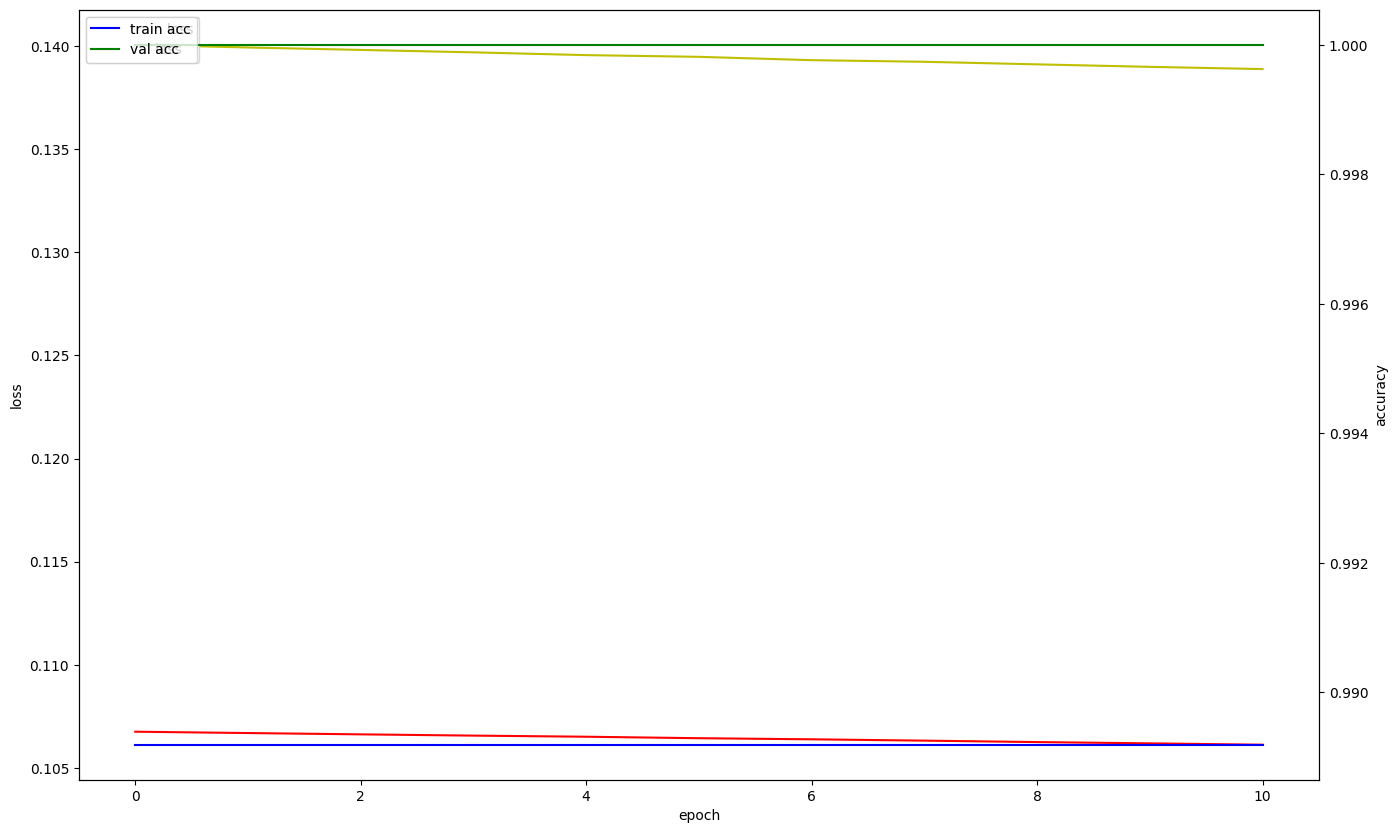

In [27]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()